In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean

import doralite
import gfdl_utils.core as gu
import CM4Xutils

import xbudget
import regionate
import xwmb
import warnings

In [92]:
def stairs(ax, wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = ax.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    ax.set_xlabel(f"mean transformation rate [{units}]")
    return l

def time_mean(ds, ds_weights=None):
    coords = ds.coords
    if ds_weights is None:
        weights = xr.DataArray(
            ds.time_bounds.diff("time_bounds").values.astype("float64"),
            coords={"time":ds.time},
            dims=("time",)
        )
    else:
        weights = xr.DataArray(
            ds_weights.time_bounds.diff("time_bounds").values.astype("float64"),
            coords={"time":ds_weights.time},
            dims=("time",)
        )
    ds_mean = ds.weighted(weights).mean("time")
    ds_mean = ds_mean.assign_coords({c:coord for (c,coord) in coords.items() if c not in ds_mean.coords})
    return ds_mean

In [93]:
toSv = 1e-6/1035.

/vftmp/Henri.Drake/pid16794/ipykernel_26216/2813989377.py:119: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pc = ax.pcolor(
/vftmp/Henri.Drake/pid16794/ipykernel_26216/2813989377.py:127: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(
/vftmp/Henri.Drake/pid16794/ipykernel_26216/2813989377.py:136: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pc = ax.pcolor(
/vftmp/Henri.Drake/pid16794/ipykerne

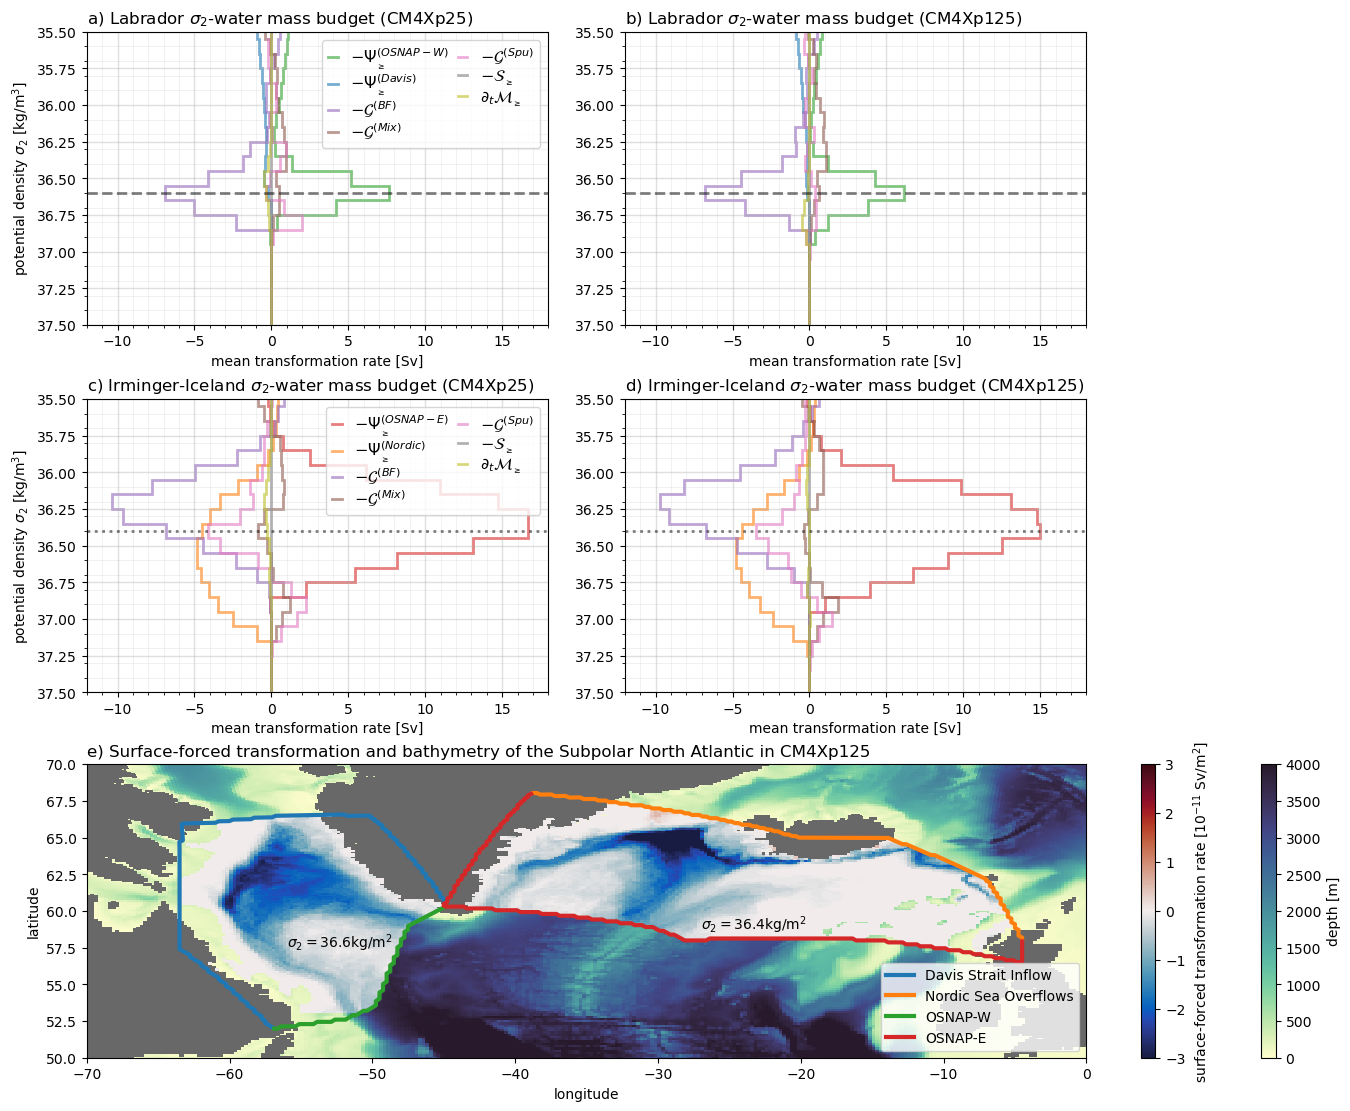

In [94]:
fig, axes = plt.subplot_mosaic([['upper left', 'upper right'],
                                ['center left', 'center right'],
                                ['lower', 'lower']],
                              figsize=(13.5, 11), layout="constrained")

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

for (col, model) in zip(["left", "right"], ["CM4Xp25", "CM4Xp125"]):
    wmt_west = time_mean(xr.open_zarr(f"../../data/wmb_{model}_Labrador_2010-2024.zarr").sel(exp="forced"))*toSv
    wmt_east = time_mean(xr.open_zarr(f"../../data/wmb_{model}_IrmingerIceland_2010-2024.zarr").sel(exp="forced"))*toSv

    sec_ranges = {
        "west": {
            "Davis Strait Inflow": np.arange(110, wmt_west.lon_sect.size),
            "OSNAP-W": np.arange(0, 110)
        },
        "east": {
            "Nordic Sea Overflows": np.arange(0, 224),
            "OSNAP-E": np.arange(224, wmt_east.lon_sect.size)
        }
    }

    wmt_west["convergent_mass_transport_Davis"] = wmt_west["convergent_mass_transport_along"].isel(sect=sec_ranges["west"]["Davis Strait Inflow"]).sum("sect")
    wmt_west["convergent_mass_transport_OSNAP-W"] = wmt_west["convergent_mass_transport_along"].isel(sect=sec_ranges["west"]["OSNAP-W"]).sum("sect")

    wmt_east["convergent_mass_transport_Nordic"] = wmt_east["convergent_mass_transport_along"].isel(sect=sec_ranges["east"]["Nordic Sea Overflows"]).sum("sect")
    wmt_east["convergent_mass_transport_OSNAP-E"] = wmt_east["convergent_mass_transport_along"].isel(sect=sec_ranges["east"]["OSNAP-E"]).sum("sect")
    
    wmt_mean = (wmt_east.drop_dims("sect") + wmt_west.drop_dims("sect"))
    
    kwargs = {"units":"Sv", "alpha":0.6, "lw":2}

    # West
    ax = axes[f"upper {col}"]
    stairs(ax,-wmt_west, 'convergent_mass_transport_OSNAP-W', label=r"$-\Psi^{(OSNAP-W)}_{_{\geq}}$", color="C2", **kwargs)
    stairs(ax,-wmt_west, 'convergent_mass_transport_Davis', label=r"$-\Psi^{(Davis)}_{_{\geq}}$", color="C0", **kwargs)
    stairs(ax, wmt_west, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$", color="C4", **kwargs)
    stairs(ax, wmt_west, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$", color="C5", **kwargs)
    stairs(ax, wmt_west, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(Spu)}$", color="C6", **kwargs)
    stairs(ax,-wmt_west, 'mass_source',               label=r"$-\mathcal{S}_{_{\geq}}$", color="C7", **kwargs)
    stairs(ax, wmt_west, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}_{_{\geq}}$", color="C8", **kwargs)
    
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(True, alpha=0.4, linewidth=1, which="major")
    ax.grid(True, alpha=0.2, linewidth=0.6, which="minor")
    if model=="CM4Xp25":
        ax.set_ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
        ax.legend(loc="upper right", handlelength=0.6, labelspacing=0.08, ncols=2, columnspacing=0.5, fontsize=11.5)
        panel="a)"
    else:
        ax.set_ylabel("")
        panel="b)"

    ax.set_title(rf"{panel} Labrador $\sigma_{{2}}$-water mass budget ({model})", loc="left")
    ax.set_ylim(37.5, 35.5);
    ax.set_xlim(-12, 18)

    # East
    ax = axes[f"center {col}"]
    stairs(ax,-wmt_east, 'convergent_mass_transport_OSNAP-E', label=r"$-\Psi^{(OSNAP-E)}_{_{\geq}}$", color="C3", **kwargs)
    stairs(ax,-wmt_east, 'convergent_mass_transport_Nordic', label=r"$-\Psi^{(Nordic)}_{_{\geq}}$", color="C1", **kwargs)
    stairs(ax, wmt_east, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$", color="C4", **kwargs)
    stairs(ax, wmt_east, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$", color="C5", **kwargs)
    stairs(ax, wmt_east, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(Spu)}$", color="C6", **kwargs)
    stairs(ax,-wmt_east, 'mass_source',               label=r"$-\mathcal{S}_{_{\geq}}$", color="C7", **kwargs)
    stairs(ax, wmt_east, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}_{_{\geq}}$", color="C8", **kwargs)
    
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(True, alpha=0.4, linewidth=1, which="major")
    ax.grid(True, alpha=0.2, linewidth=0.6, which="minor")
    if model=="CM4Xp25":
        ax.set_ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
        ax.legend(loc="upper right", handlelength=0.6, labelspacing=0.08, ncols=2, columnspacing=0.5, fontsize=11.5)
        panel="c)"
    else:
        ax.set_ylabel("")
        panel="d)"
    ax.set_title(rf"{panel} Irminger-Iceland $\sigma_{{2}}$-water mass budget ({model})", loc="left")
    ax.set_ylim(37.5, 35.5);
    ax.set_xlim(-12, 18)

# Surface water mass transformation maps
ax = axes["lower"]
model = "CM4Xp125"

wmt_east = xr.open_zarr(f"../../data/wmb_{model}_IrmingerIceland_2010-2024.zarr") * toSv
wmt_west = xr.open_zarr(f"../../data/wmb_{model}_Labrador_2010-2024.zarr") * toSv
wmt_mean = time_mean((wmt_east.drop_dims("sect") + wmt_west.drop_dims("sect")).sel(exp="forced"))

wmt_map_west = xr.concat([
    xr.open_zarr(f"../../data/wmb_boundary_flux_maps_CM4Xp125_Labrador_2010-2014.zarr").sel(exp="forced"),
    xr.open_zarr(f"../../data/wmb_boundary_flux_maps_CM4Xp125_Labrador_2015-2019.zarr").sel(exp="forced"),
    xr.open_zarr(f"../../data/wmb_boundary_flux_maps_CM4Xp125_Labrador_2020-2024.zarr").sel(exp="forced")
], dim="time").mean("time")
wmt_map_east = xr.concat([
    xr.open_zarr(f"../../data/wmb_boundary_flux_maps_CM4Xp125_IrmingerIceland_2010-2014.zarr").sel(exp="forced"),
    xr.open_zarr(f"../../data/wmb_boundary_flux_maps_CM4Xp125_IrmingerIceland_2015-2019.zarr").sel(exp="forced"),
    xr.open_zarr(f"../../data/wmb_boundary_flux_maps_CM4Xp125_IrmingerIceland_2020-2024.zarr").sel(exp="forced")
], dim="time").mean("time")

axes["upper left"].axhline(wmt_map_west.sigma2_l_target.values, color="k", alpha=0.5, lw=2, ls="--")
axes["upper right"].axhline(wmt_map_west.sigma2_l_target.values, color="k", alpha=0.5, lw=2, ls="--")
axes["center left"].axhline(wmt_map_east.sigma2_l_target.values, color="k", alpha=0.5, lw=2, ls=":")
axes["center right"].axhline(wmt_map_east.sigma2_l_target.values, color="k", alpha=0.5, lw=2, ls=":")

sec_ranges = {
    "west": {
        "Davis Strait Inflow": np.arange(110, wmt_west.lon_sect.size),
        "OSNAP-W": np.arange(0, 110)
    },
    "east": {
        "Nordic Sea Overflows": np.arange(0, 224),
        "OSNAP-E": np.arange(224, wmt_east.lon_sect.size)
    }
}

pc = ax.pcolor(
    wmt_east.geolon,
    wmt_east.geolat,
    wmt_east.deptho,
    cmap=cmocean.cm.deep,
    vmin=0, vmax=4000
)
plt.colorbar(pc, label="depth [m]")
ax.pcolor(
    wmt_east.geolon,
    wmt_east.geolat,
    wmt_east.deptho.where(wmt_east.deptho==0)+1.,
    cmap="Greys", vmin=0, vmax=1.5
)

swmt = (wmt_map_west['boundary_fluxes'] + wmt_map_east['boundary_fluxes'])/wmt_map_west['areacello']*toSv*1e11
swmt = swmt.where(swmt!=0)
pc = ax.pcolor(
    wmt_map_west['geolon'],
    wmt_map_west['geolat'],
    swmt,
    cmap=cmocean.cm.balance,
    vmin=-3,
    vmax=3
)
plt.colorbar(pc, label=r"surface-forced transformation rate [10$^{-11}$ Sv/m$^{2}$]")

ax.annotate(rf"$\sigma_{{2}} = ${wmt_map_west.sigma2_l_target.values}kg/m$^{{2}}$", xy=(-56, 57.5), xycoords="data")
ax.annotate(rf"$\sigma_{{2}} = ${wmt_map_east.sigma2_l_target.values}kg/m$^{{2}}$", xy=(-27, 58.75), xycoords="data")

def plot_section(sname):
    if sname in sec_ranges["west"]:
        sidx = sec_ranges["west"][sname]
        ax.plot(wmt_west.lon_sect[sidx], wmt_west.lat_sect[sidx], label=sname, lw=3)
    elif sname in sec_ranges["east"]:
        sidx = sec_ranges["east"][sname]
        ax.plot(wmt_east.lon_sect[sidx], wmt_east.lat_sect[sidx], label=sname, lw=3)
        
plot_section("Davis Strait Inflow")
plot_section("Nordic Sea Overflows")
plot_section("OSNAP-W")
plot_section("OSNAP-E")

ax.legend()
ax.set_xlabel("longitude");
ax.set_ylabel("latitude");
ax.set_xlim(-70, 0)
ax.set_ylim(50, 70);

axes["lower"].set_title("e) Surface-forced transformation and bathymetry of the Subpolar North Atlantic in CM4Xp125", loc="left")

fig.savefig("../../figures/SPNA_transformations_and_overturning.png", dpi=300, bbox_inches="tight")